# Music Genre Classification: Model Development and Comparison (Tyler)

## 1. Introduction

This notebook aims to develop a robust machine learning model to classify music tracks into their respective genres using a comprehensive Spotify dataset. Building upon initial exploratory analysis and baseline modeling, we implement a series of enhancements to improve model performance, address class imbalance, explore alternative algorithms, and leverage advanced techniques. The final section compares the performance of all models to identify the most effective approach for genre classification

## 2. Import Libraries

We begin by importing the necessary libraries for data manipulation, visualization, and machine learning.

In [1]:
# Data Manipulation Libraries
import pandas as pd
import numpy as np

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Libraries
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_score,
    StratifiedKFold,
)
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
)

from sklearn.metrics import precision_recall_curve, average_precision_score
from itertools import cycle

# Advanced Libraries
from imblearn.combine import SMOTETomek
from xgboost import XGBClassifier

# Suppress Warnings for Clean Output
import warnings

warnings.filterwarnings("ignore")

# Set Plot Style
sns.set(style="whitegrid")

## 3. Load and Inspect the Data

Load the dataset and perform initial inspections to understand its structure and identify any data quality issues.

In [2]:
# Load the dataset
data = pd.read_csv("data/ClassicHit.csv")

# Display the first few rows
data.head()

,Track,Artist,Year,Duration,Time_Signature,Danceability,Energy,Key,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Popularity,Genre
0,Hey Jack Kerouac,"10,000 Maniacs",1987,206413,4,0.616,0.511,6,-15.894,1,0.0279,0.03840,0.000000,0.1500,0.604,132.015,40,Alt. Rock
1,Like the Weather,"10,000 Maniacs",1987,236653,4,0.770,0.459,1,-17.453,1,0.0416,0.11200,0.003430,0.1450,0.963,133.351,43,Alt. Rock
2,What's the Matter Here?,"10,000 Maniacs",1987,291173,4,0.593,0.816,9,-7.293,1,0.0410,0.00449,0.000032,0.0896,0.519,99.978,12,Alt. Rock
3,Trouble Me,"10,000 Maniacs",1989,193560,4,0.861,0.385,2,-10.057,1,0.0341,0.15400,0.000000,0.1230,0.494,117.913,47,Alt. Rock
4,Candy Everybody Wants,"10,000 Maniacs",1992,185960,4,0.622,0.876,10,-6.310,1,0.0305,0.01930,0.006840,0.0987,0.867,104.970,43,Alt. Rock


In [3]:
# Inspect the dataset structure
print(data.info())

# Check for missing values
print("\nMissing Values:\n", data.isnull().sum())

# Check for duplicate entries based on Artist and Track
duplicate_count = data.duplicated(subset=["Artist", "Track"]).sum()
print(f"\nNumber of duplicate entries based on Artist and Track: {duplicate_count}")

# Remove duplicate entries if any
data = data.drop_duplicates(subset=["Artist", "Track"])

# Verify removal
print(f"Dataset shape after removing duplicates: {data.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15150 entries, 0 to 15149
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Track             15150 non-null  object 
 1   Artist            15150 non-null  object 
 2   Year              15150 non-null  int64  
 3   Duration          15150 non-null  int64  
 4   Time_Signature    15150 non-null  int64  
 5   Danceability      15150 non-null  float64
 6   Energy            15150 non-null  float64
 7   Key               15150 non-null  int64  
 8   Loudness          15150 non-null  float64
 9   Mode              15150 non-null  int64  
 10  Speechiness       15150 non-null  float64
 11  Acousticness      15150 non-null  float64
 12  Instrumentalness  15150 non-null  float64
 13  Liveness          15150 non-null  float64
 14  Valence           15150 non-null  float64
 15  Tempo             15150 non-null  float64
 16  Popularity        15150 non-null  int64 

## 4. Data Encoding and Feature Selection

Encode the target variable and select relevant features for modeling.

In [4]:
# Encode the target variable 'Genre'
label_encoder = LabelEncoder()
data["Genre_encoded"] = label_encoder.fit_transform(data["Genre"])

# Display the mapping of genres to encoded labels
genre_mapping = dict(
    zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))
)
print("Genre Encoding Mapping:\n", genre_mapping)

Genre Encoding Mapping:
 {'Alt. Rock': np.int64(0), 'Blues': np.int64(1), 'Country': np.int64(2), 'Disco': np.int64(3), 'EDM': np.int64(4), 'Folk': np.int64(5), 'Funk': np.int64(6), 'Gospel': np.int64(7), 'Jazz': np.int64(8), 'Metal': np.int64(9), 'Pop': np.int64(10), 'Punk': np.int64(11), 'R&B': np.int64(12), 'Rap': np.int64(13), 'Reggae': np.int64(14), 'Rock': np.int64(15), 'SKA': np.int64(16), 'Today': np.int64(17), 'World': np.int64(18)}


In [5]:
# Select relevant features based on EDA
feature_columns = [
    "Danceability",
    "Energy",
    "Loudness",
    "Speechiness",
    "Acousticness",
    "Instrumentalness",
    "Liveness",
    "Valence",
    "Tempo",
    "Popularity",
]

X = data[feature_columns]
y = data["Genre_encoded"]

# Display feature statistics before scaling
X.describe().T

,count,mean,std,min,25%,50%,75%,max
Danceability,14871.0,0.574312,0.166080,0.000000,0.4610,0.581000,0.69500,0.988
Energy,14871.0,0.616591,0.239827,0.000098,0.4400,0.642000,0.81800,0.999
Loudness,14871.0,-9.164678,4.303677,-47.359000,-11.7645,-8.485000,-5.95400,0.919
Speechiness,14871.0,0.075735,0.077812,0.000000,0.0343,0.046300,0.07815,0.950
Acousticness,14871.0,0.304231,0.318304,0.000001,0.0244,0.169000,0.56150,0.996
Instrumentalness,14871.0,0.091432,0.229720,0.000000,0.0000,0.000082,0.01250,0.987
Liveness,14871.0,0.200342,0.175741,0.012400,0.0919,0.130000,0.25700,0.996
Valence,14871.0,0.569876,0.251060,0.000000,0.3700,0.584000,0.78100,0.989
Tempo,14871.0,120.689546,29.216601,0.000000,98.6465,118.808000,138.10700,219.973
Popularity,14871.0,42.905588,20.815692,0.000000,28.0000,44.000000,59.00000,98.000


## 5. Handling Class Imbalance

Address class imbalance using SMOTETomek to ensure the model learns equally from all genres.

In [6]:
# Split the data into training and testing sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

Training set shape: (11896, 10)
Testing set shape: (2975, 10)


In [7]:
# Apply SMOTETomek to the training data
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled, y_train_resampled = smote_tomek.fit_resample(X_train, y_train)

print(f"Training set shape after SMOTETomek: {X_train_resampled.shape}")
print(
    f"Class distribution after SMOTETomek:\n{pd.Series(y_train_resampled).value_counts()}"
)

Training set shape after SMOTETomek: (51450, 10)
Class distribution after SMOTETomek:
Genre_encoded
4     2791
7     2777
16    2777
8     2755
18    2749
13    2746
14    2735
6     2735
5     2732
17    2731
9     2725
3     2723
1     2710
0     2692
15    2692
11    2691
2     2675
12    2644
10    2370
Name: count, dtype: int64


## 6. Feature Scaling and Transformation

Based on the EDA, apply log transformations to skewed features and standardize all features to ensure uniform scaling.

In [8]:
# Define a function for log transformation
def log_transform(series):
    return np.log1p(series - series.min() + 1)

In [9]:
# Features identified as skewed in EDA
features_to_transform = [
    "Loudness",
    "Speechiness",
    "Acousticness",
    "Instrumentalness",
    "Liveness",
]

# Apply log transformation to skewed features in training and testing data
for feature in features_to_transform:
    if feature in X_train_resampled.columns:
        X_train_resampled[feature] = log_transform(X_train_resampled[feature])
        X_test[feature] = log_transform(X_test[feature])

In [10]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform both training and testing data
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Convert scaled data back to DataFrame for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_columns)

## 7. Baseline Model: DummyClassifier

Establish a baseline using a DummyClassifier to understand the minimum performance expectations.

In [11]:
# Initialize DummyClassifier with a stratified strategy
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)

# Train the DummyClassifier
dummy_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_dummy = dummy_clf.predict(X_test_scaled)

# Evaluate the DummyClassifier
dummy_accuracy = accuracy_score(y_test, y_pred_dummy)
print(f"DummyClassifier Accuracy: {dummy_accuracy:.4f}")

# Display classification report
print("\nClassification Report for DummyClassifier:\n")
print(classification_report(y_test, y_pred_dummy, target_names=label_encoder.classes_))

DummyClassifier Accuracy: 0.0477

Classification Report for DummyClassifier:

              precision    recall  f1-score   support

   Alt. Rock       0.03      0.03      0.03       156
       Blues       0.03      0.04      0.04       136
     Country       0.07      0.05      0.06       167
       Disco       0.03      0.03      0.03       130
         EDM       0.06      0.06      0.06       140
        Folk       0.03      0.04      0.04       112
        Funk       0.00      0.00      0.00        70
      Gospel       0.04      0.11      0.06        61
        Jazz       0.03      0.03      0.03       156
       Metal       0.04      0.03      0.03       177
         Pop       0.26      0.05      0.09       727
        Punk       0.07      0.08      0.08       149
         R&B       0.07      0.07      0.07       153
         Rap       0.04      0.05      0.04       144
      Reggae       0.04      0.07      0.05        87
        Rock       0.01      0.01      0.01       158
   

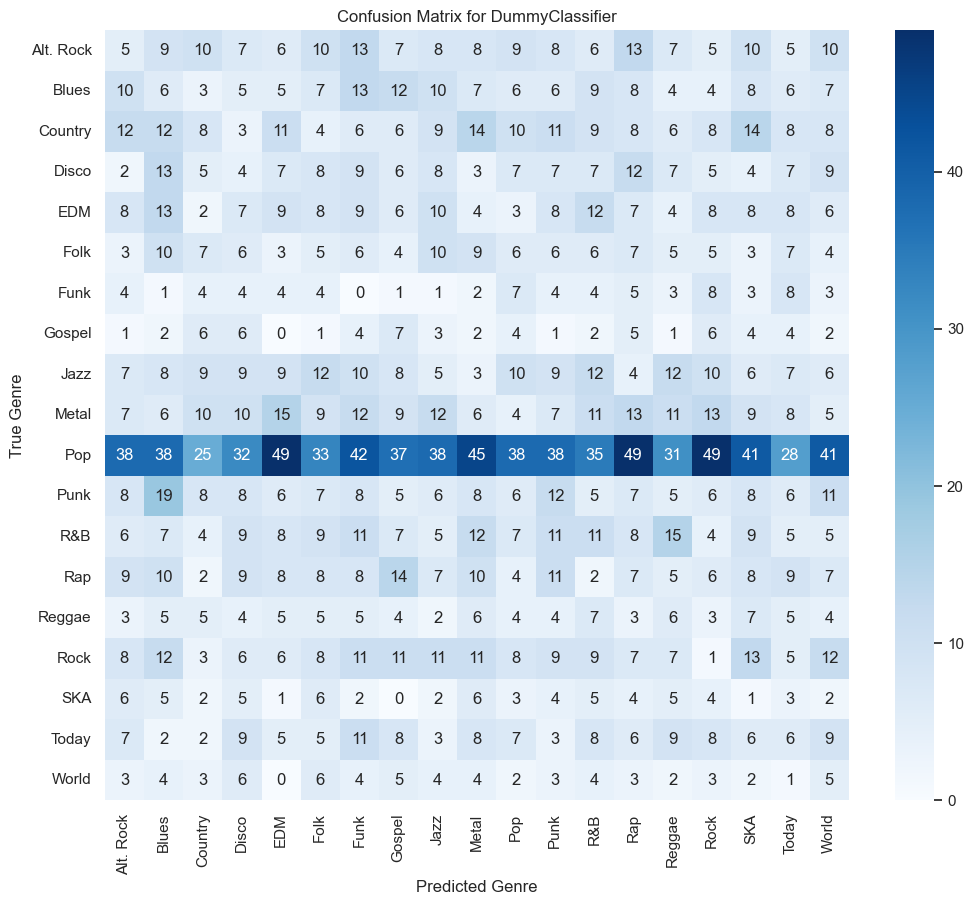

In [12]:
# Confusion Matrix for DummyClassifier

# Compute confusion matrix
conf_matrix_dummy = confusion_matrix(y_test, y_pred_dummy)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_dummy,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Confusion Matrix for DummyClassifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## 8. Advanced Models: Random Forest, SVM, XGBoost, and KNN

Train and evaluate multiple advanced classifiers to benchmark against the baseline.

### a. Random Forest Classifier

In [13]:
# Initialize the Random Forest Classifier with class_weight='balanced'
rf_clf = RandomForestClassifier(
    n_estimators=100, random_state=42, class_weight="balanced"
)

# Train the Random Forest model
rf_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_rf = rf_clf.predict(X_test_scaled)

# Evaluate the Random Forest model
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.4f}")

# Display classification report
print("\nClassification Report for Random Forest Classifier:\n")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

Random Forest Classifier Accuracy: 0.3539

Classification Report for Random Forest Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.29      0.28      0.28       156
       Blues       0.29      0.17      0.21       136
     Country       0.18      0.49      0.27       167
       Disco       0.29      0.46      0.35       130
         EDM       0.78      0.18      0.29       140
        Folk       0.16      0.26      0.20       112
        Funk       0.08      0.04      0.06        70
      Gospel       0.31      0.18      0.23        61
        Jazz       0.46      0.48      0.47       156
       Metal       0.44      0.48      0.46       177
         Pop       0.49      0.46      0.48       727
        Punk       0.36      0.56      0.44       149
         R&B       0.19      0.10      0.13       153
         Rap       0.56      0.55      0.55       144
      Reggae       0.47      0.45      0.46        87
        Rock       0.31      0.34      

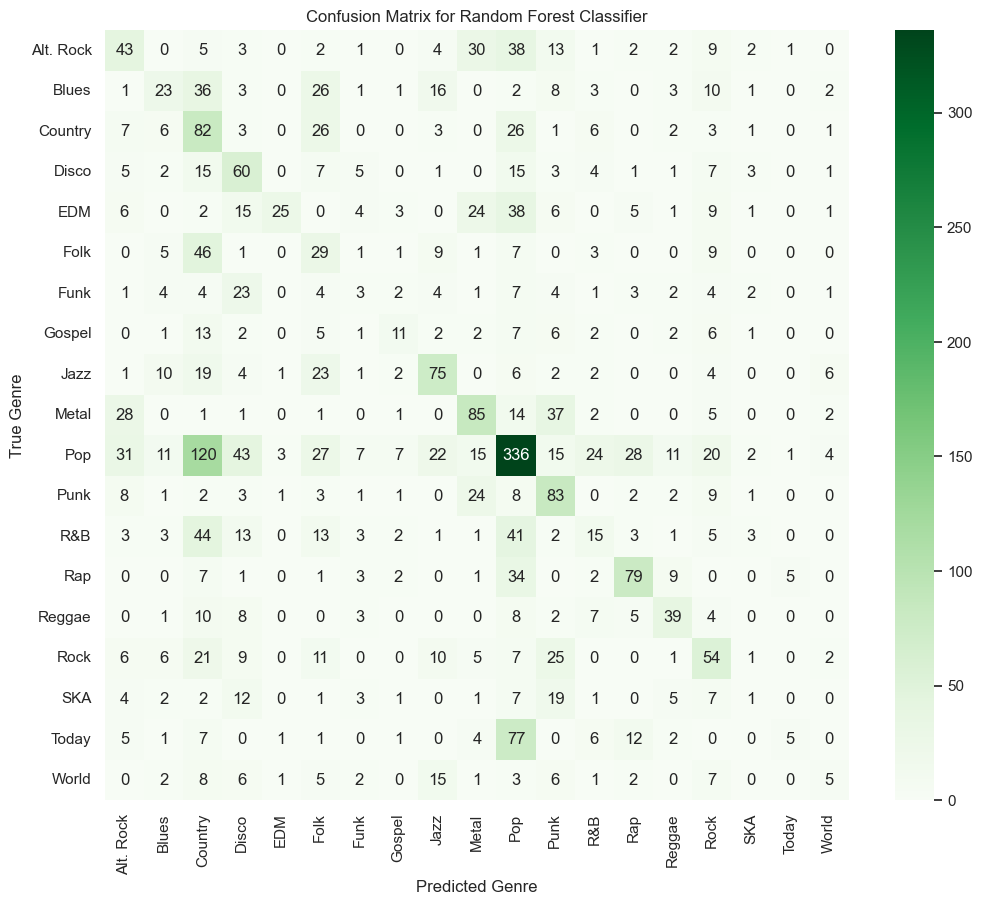

In [14]:
# Confusion Matrix for Random Forest Classifier

# Compute confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Confusion Matrix for Random Forest Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### b. Support Vector Machines (SVM)

In [15]:
# Initialize the SVM classifier with probability estimates
svm_clf = SVC(probability=True, random_state=42)

# Train the SVM model
svm_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_svm = svm_clf.predict(X_test_scaled)

# Evaluate the SVM model
svm_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"SVM Classifier Accuracy: {svm_accuracy:.4f}")

# Display classification report
print("\nClassification Report for SVM Classifier:\n")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

SVM Classifier Accuracy: 0.2844

Classification Report for SVM Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.08      0.01      0.01       156
       Blues       0.20      0.19      0.20       136
     Country       0.19      0.07      0.10       167
       Disco       0.16      0.08      0.10       130
         EDM       1.00      0.01      0.03       140
        Folk       0.07      0.08      0.08       112
        Funk       0.17      0.06      0.09        70
      Gospel       1.00      0.02      0.03        61
        Jazz       0.25      0.26      0.25       156
       Metal       0.33      0.32      0.32       177
         Pop       0.33      0.72      0.46       727
        Punk       0.32      0.36      0.34       149
         R&B       0.07      0.01      0.01       153
         Rap       0.56      0.38      0.45       144
      Reggae       0.36      0.10      0.16        87
        Rock       0.35      0.22      0.27       158
     

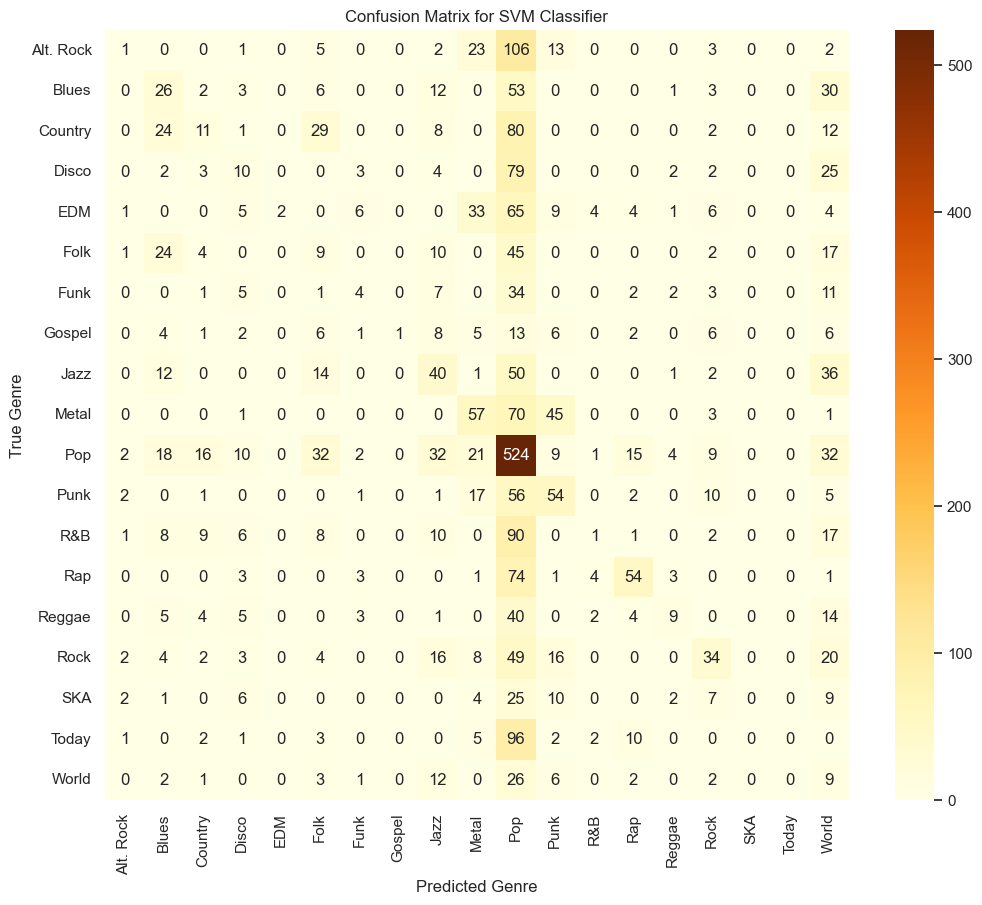

In [16]:
# Confusion Matrix for SVM Classifier

# Compute confusion matrix
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_svm,
    annot=True,
    fmt="d",
    cmap="YlOrBr",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Confusion Matrix for SVM Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### c. XGBoost Classifier

In [17]:
# Initialize the XGBoost classifier
xgb_clf = XGBClassifier(
    random_state=42, use_label_encoder=False, eval_metric="mlogloss"
)

# Train the XGBoost model
xgb_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_xgb = xgb_clf.predict(X_test_scaled)

# Evaluate the XGBoost model
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Classifier Accuracy: {xgb_accuracy:.4f}")

# Display classification report
print("\nClassification Report for XGBoost Classifier:\n")
print(classification_report(y_test, y_pred_xgb, target_names=label_encoder.classes_))

XGBoost Classifier Accuracy: 0.3392

Classification Report for XGBoost Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.21      0.16      0.18       156
       Blues       0.36      0.18      0.24       136
     Country       0.19      0.28      0.23       167
       Disco       0.27      0.27      0.27       130
         EDM       1.00      0.06      0.12       140
        Folk       0.21      0.24      0.22       112
        Funk       0.17      0.06      0.09        70
      Gospel       0.56      0.08      0.14        61
        Jazz       0.54      0.37      0.44       156
       Metal       0.50      0.31      0.38       177
         Pop       0.40      0.64      0.49       727
        Punk       0.36      0.52      0.43       149
         R&B       0.03      0.01      0.01       153
         Rap       0.55      0.42      0.48       144
      Reggae       0.46      0.43      0.44        87
        Rock       0.21      0.46      0.29       1

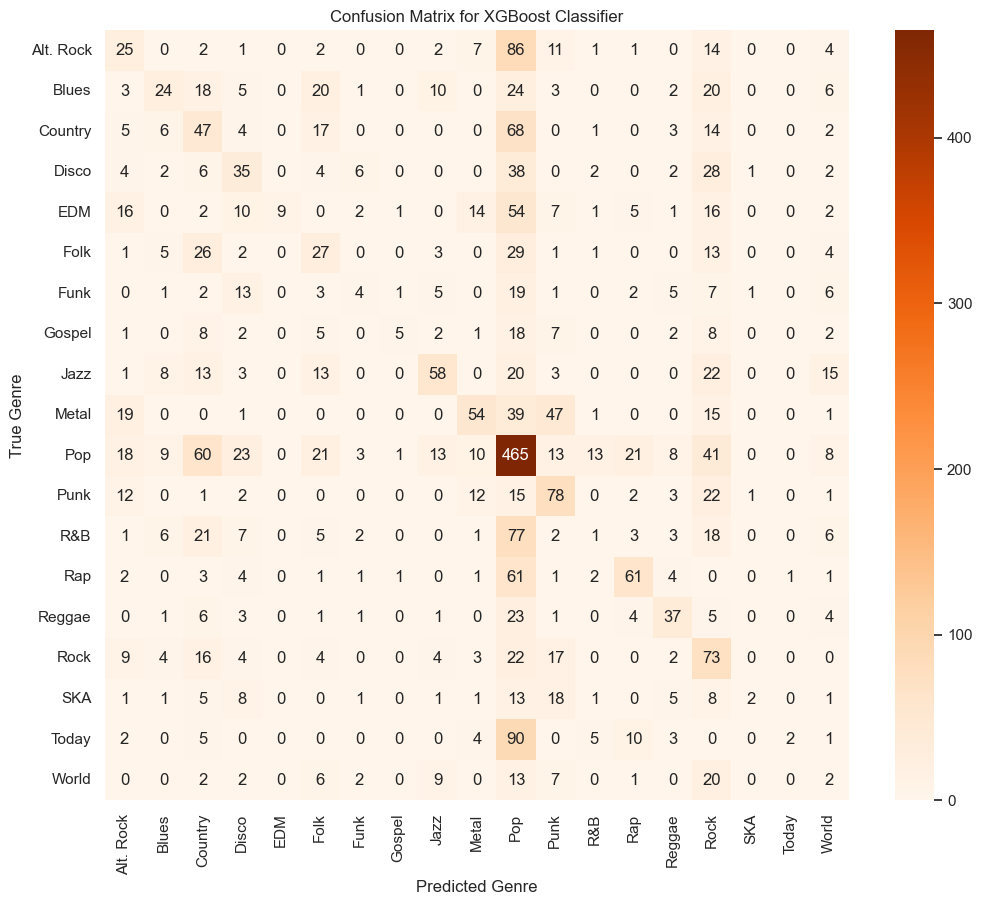

In [18]:
# Confusion Matrix for XGBoost Classifier

# Compute confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_xgb,
    annot=True,
    fmt="d",
    cmap="Oranges",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Confusion Matrix for XGBoost Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### d. K-Nearest Neighbors (KNN)

In [19]:
# Initialize the K-Nearest Neighbors classifier
knn_clf = KNeighborsClassifier(n_neighbors=len(label_encoder.classes_))

# Train the KNN model
knn_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_knn = knn_clf.predict(X_test_scaled)

# Evaluate the KNN model
knn_accuracy = accuracy_score(y_test, y_pred_knn)
print(f"K-Nearest Neighbors Classifier Accuracy: {knn_accuracy:.4f}")

# Display classification report
print("\nClassification Report for K-Nearest Neighbors Classifier:\n")
print(classification_report(y_test, y_pred_knn, target_names=label_encoder.classes_))

K-Nearest Neighbors Classifier Accuracy: 0.1738

Classification Report for K-Nearest Neighbors Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.19      0.10      0.13       156
       Blues       0.15      0.41      0.22       136
     Country       0.08      0.13      0.10       167
       Disco       0.12      0.20      0.15       130
         EDM       0.78      0.05      0.09       140
        Folk       0.08      0.23      0.11       112
        Funk       0.03      0.04      0.04        70
      Gospel       0.20      0.05      0.08        61
        Jazz       0.21      0.45      0.29       156
       Metal       0.31      0.42      0.36       177
         Pop       0.42      0.08      0.14       727
        Punk       0.36      0.32      0.34       149
         R&B       0.04      0.05      0.05       153
         Rap       0.57      0.25      0.35       144
      Reggae       0.19      0.38      0.25        87
        Rock       0.30    

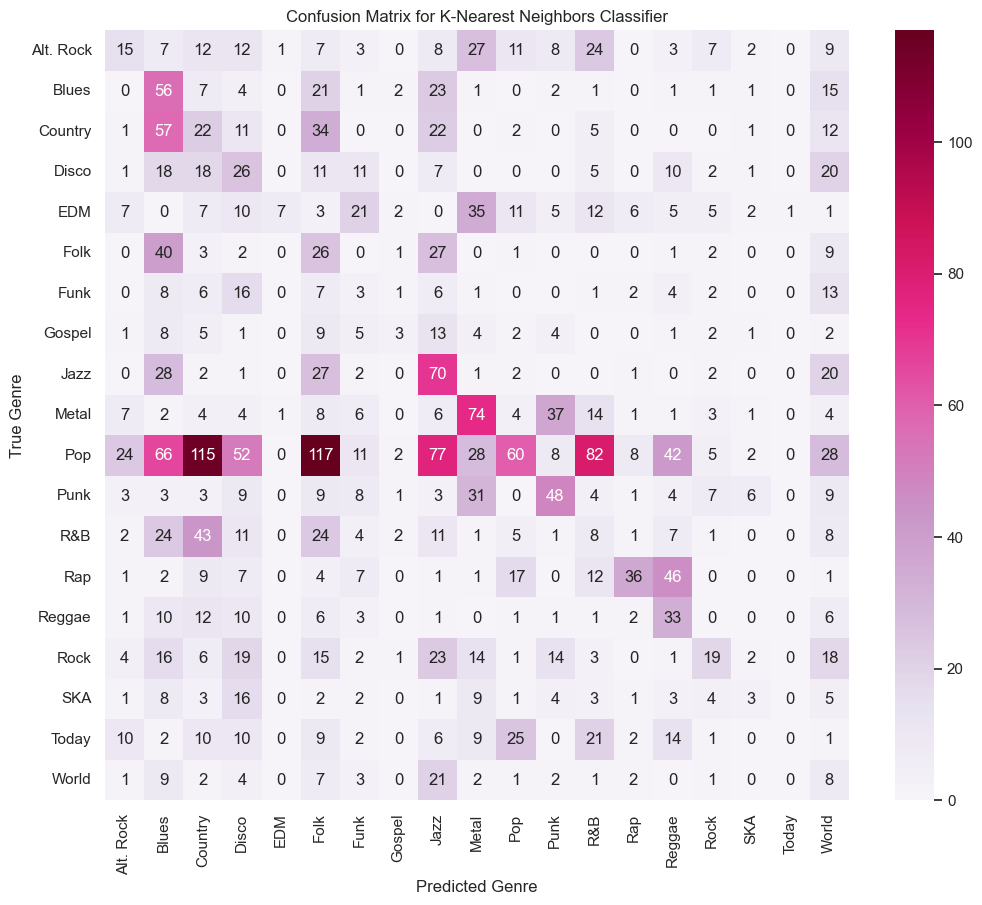

In [20]:
# Confusion Matrix for K-Nearest Neighbors Classifier

# Compute confusion matrix
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_knn,
    annot=True,
    fmt="d",
    cmap="PuRd",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Confusion Matrix for K-Nearest Neighbors Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## 9. Hyperparameter Tuning for Random Forest and XGBoost

Optimize the hyperparameters of Random Forest and XGBoost classifiers using GridSearchCV to enhance performance.

### a. Hyperparameter Tuning for Random Forest

In [21]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    "n_estimators": [100, 200, 300],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "bootstrap": [True, False],
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="accuracy",
)

# Fit GridSearchCV on the training data
grid_search_rf.fit(X_train_scaled, y_train_resampled)

# Best parameters found
print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

# Best estimator
best_rf = grid_search_rf.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters for Random Forest: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [22]:
# Make predictions with the best Random Forest model
y_pred_best_rf = best_rf.predict(X_test_scaled)

# Evaluate the best Random Forest model
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)
print(f"Tuned Random Forest Classifier Accuracy: {best_rf_accuracy:.4f}")

# Display classification report
print("\nClassification Report for Tuned Random Forest Classifier:\n")
print(
    classification_report(y_test, y_pred_best_rf, target_names=label_encoder.classes_)
)

Tuned Random Forest Classifier Accuracy: 0.3650

Classification Report for Tuned Random Forest Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.32      0.29      0.30       156
       Blues       0.35      0.19      0.25       136
     Country       0.19      0.52      0.28       167
       Disco       0.29      0.42      0.35       130
         EDM       0.77      0.16      0.27       140
        Folk       0.16      0.21      0.18       112
        Funk       0.11      0.04      0.06        70
      Gospel       0.39      0.18      0.25        61
        Jazz       0.49      0.53      0.51       156
       Metal       0.48      0.53      0.50       177
         Pop       0.48      0.50      0.49       727
        Punk       0.34      0.56      0.42       149
         R&B       0.18      0.09      0.12       153
         Rap       0.57      0.54      0.55       144
      Reggae       0.44      0.44      0.44        87
        Rock       0.30    

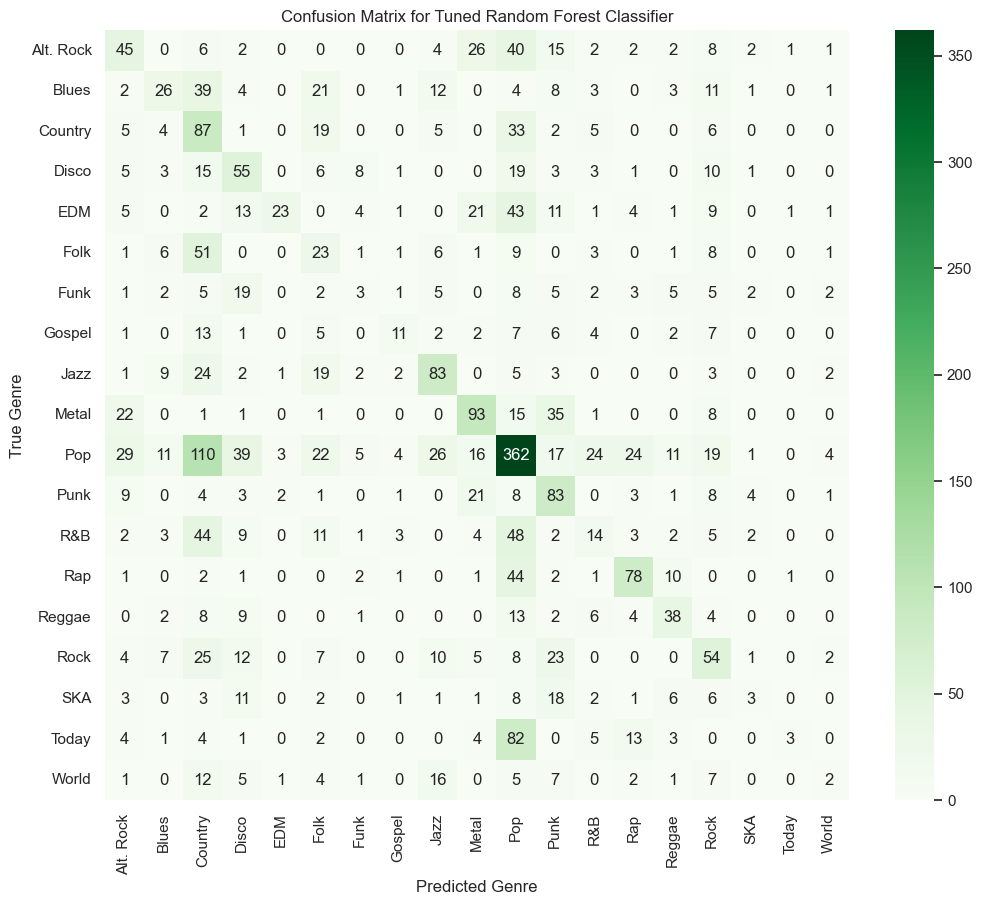

In [23]:
# Confusion Matrix for Tuned Random Forest Classifier

# Compute confusion matrix
conf_matrix_best_rf = confusion_matrix(y_test, y_pred_best_rf)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_best_rf,
    annot=True,
    fmt="d",
    cmap="Greens",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Confusion Matrix for Tuned Random Forest Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

### b. Hyperparameter Tuning for XGBoost

In [24]:
# Define the parameter grid for XGBoost
param_grid_xgb = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.7, 1.0],
    "colsample_bytree": [0.7, 1.0],
}

# Initialize GridSearchCV for XGBoost
grid_search_xgb = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid_xgb,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring="accuracy",
)

# Fit GridSearchCV on the training data
grid_search_xgb.fit(X_train_scaled, y_train_resampled)

# Best parameters found
print("Best Parameters for XGBoost:", grid_search_xgb.best_params_)

# Best estimator
best_xgb = grid_search_xgb.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best Parameters for XGBoost: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.7}


In [25]:
# Make predictions with the best XGBoost model
y_pred_best_xgb = best_xgb.predict(X_test_scaled)

# Evaluate the best XGBoost model
best_xgb_accuracy = accuracy_score(y_test, y_pred_best_xgb)
print(f"Tuned XGBoost Classifier Accuracy: {best_xgb_accuracy:.4f}")

# Display classification report
print("\nClassification Report for Tuned XGBoost Classifier:\n")
print(
    classification_report(y_test, y_pred_best_xgb, target_names=label_encoder.classes_)
)

Tuned XGBoost Classifier Accuracy: 0.3556

Classification Report for Tuned XGBoost Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.22      0.16      0.19       156
       Blues       0.38      0.18      0.24       136
     Country       0.21      0.40      0.28       167
       Disco       0.24      0.37      0.29       130
         EDM       0.82      0.10      0.18       140
        Folk       0.23      0.21      0.22       112
        Funk       0.19      0.07      0.10        70
      Gospel       0.33      0.07      0.11        61
        Jazz       0.49      0.44      0.46       156
       Metal       0.56      0.37      0.44       177
         Pop       0.42      0.64      0.51       727
        Punk       0.33      0.52      0.40       149
         R&B       0.11      0.03      0.04       153
         Rap       0.55      0.44      0.49       144
      Reggae       0.46      0.38      0.42        87
        Rock       0.26      0.37      

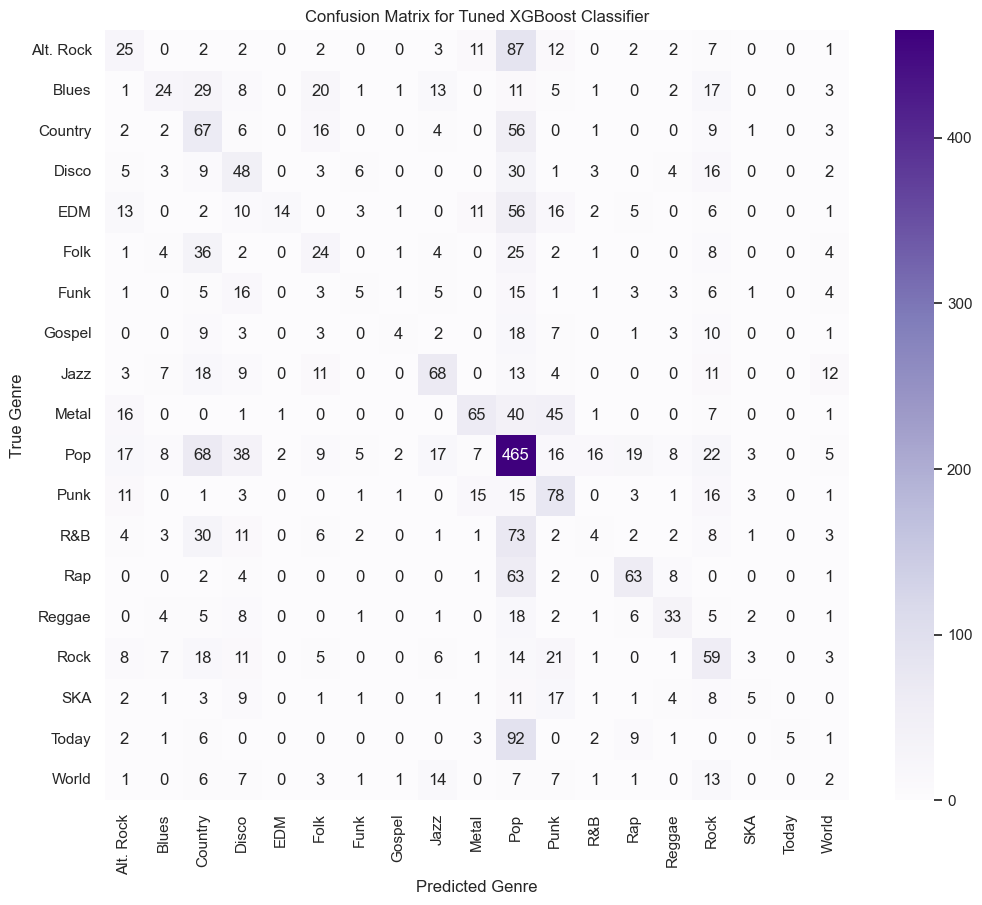

In [26]:
# Confusion Matrix for Tuned XGBoost Classifier

# Compute confusion matrix
conf_matrix_best_xgb = confusion_matrix(y_test, y_pred_best_xgb)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_best_xgb,
    annot=True,
    fmt="d",
    cmap="Purples",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Confusion Matrix for Tuned XGBoost Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## 10. Ensemble Methods: Voting Classifier

Combine multiple models to leverage their strengths and improve overall performance. The Voting Classifier now includes Random Forest, SVM, XGBoost, and KNN.

In [27]:
# Initialize the best models
models_ensemble = {
    "Random Forest": best_rf,
    "SVM": svm_clf,
    "XGBoost": best_xgb,
    "KNN": knn_clf,
}

# Initialize Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ("rf", models_ensemble["Random Forest"]),
        ("svm", models_ensemble["SVM"]),
        ("xgb", models_ensemble["XGBoost"]),
        ("knn", models_ensemble["KNN"]),
    ],
    voting="soft",
)  # 'soft' voting uses predicted class probabilities

# Train the Voting Classifier
voting_clf.fit(X_train_scaled, y_train_resampled)

# Make predictions on the test set
y_pred_voting = voting_clf.predict(X_test_scaled)

# Evaluate the Voting Classifier
voting_accuracy = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {voting_accuracy:.4f}")

# Display classification report
print("\nClassification Report for Voting Classifier:\n")
print(classification_report(y_test, y_pred_voting, target_names=label_encoder.classes_))

Voting Classifier Accuracy: 0.3634

Classification Report for Voting Classifier:

              precision    recall  f1-score   support

   Alt. Rock       0.22      0.08      0.12       156
       Blues       0.32      0.32      0.32       136
     Country       0.23      0.34      0.28       167
       Disco       0.29      0.37      0.33       130
         EDM       0.85      0.08      0.14       140
        Folk       0.19      0.25      0.22       112
        Funk       0.19      0.07      0.10        70
      Gospel       0.44      0.07      0.11        61
        Jazz       0.43      0.51      0.47       156
       Metal       0.47      0.43      0.45       177
         Pop       0.42      0.64      0.51       727
        Punk       0.35      0.53      0.42       149
         R&B       0.04      0.01      0.01       153
         Rap       0.57      0.48      0.52       144
      Reggae       0.44      0.41      0.43        87
        Rock       0.32      0.37      0.34       158

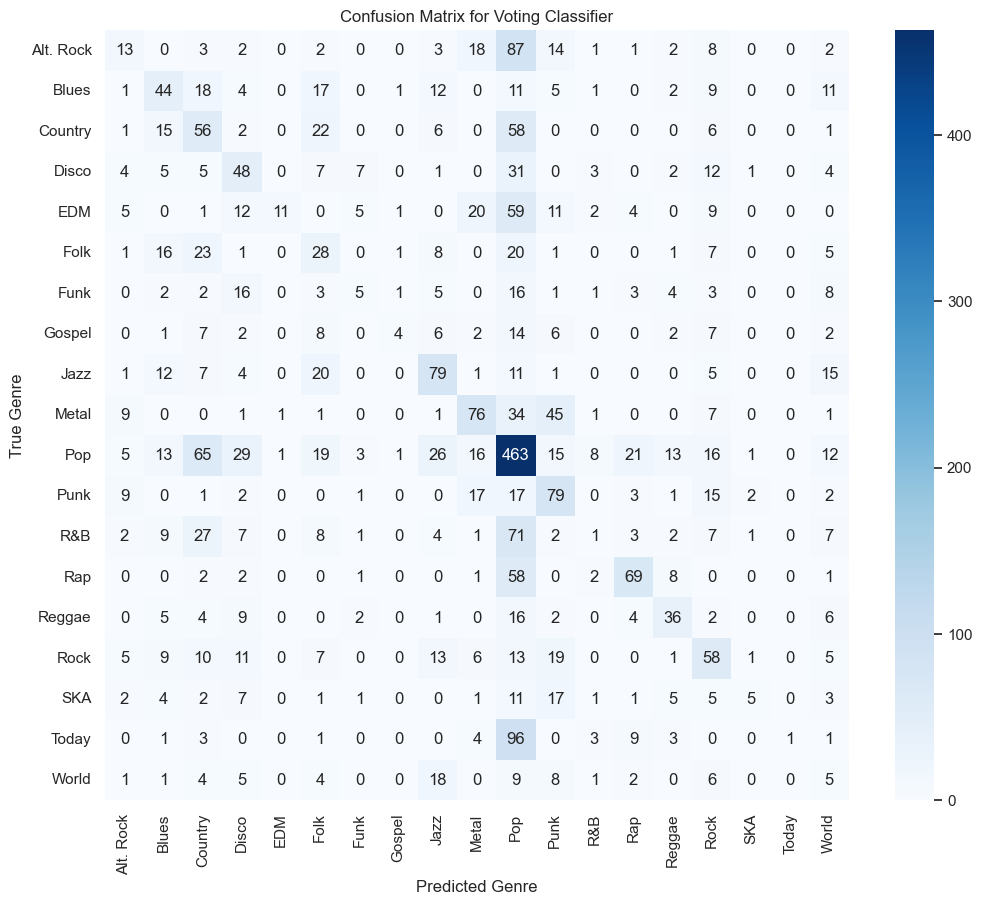

In [28]:
# Confusion Matrix for Voting Classifier

# Compute confusion matrix
conf_matrix_voting = confusion_matrix(y_test, y_pred_voting)

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_matrix_voting,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_,
)
plt.title("Confusion Matrix for Voting Classifier")
plt.xlabel("Predicted Genre")
plt.ylabel("True Genre")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## 11. Comparative Analysis of Models

Compare all developed models to identify the best-performing approach.

In [29]:
# Compile accuracy scores
model_names = [
    "DummyClassifier",
    "Random Forest",
    "Tuned Random Forest with SMOTETomek",
    "SVM",
    "XGBoost",
    "Tuned XGBoost",
    "KNN",
    "Voting Classifier",
]
accuracies = [
    dummy_accuracy,
    rf_accuracy,
    best_rf_accuracy,
    svm_accuracy,
    xgb_accuracy,
    best_xgb_accuracy,
    knn_accuracy,
    voting_accuracy,
]

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({"Model": model_names, "Accuracy": accuracies})

print(comparison_df)

                                 Model  Accuracy
0                      DummyClassifier  0.047731
1                        Random Forest  0.353950
2  Tuned Random Forest with SMOTETomek  0.365042
3                                  SVM  0.284370
4                              XGBoost  0.339160
5                        Tuned XGBoost  0.355630
6                                  KNN  0.173782
7                    Voting Classifier  0.363361


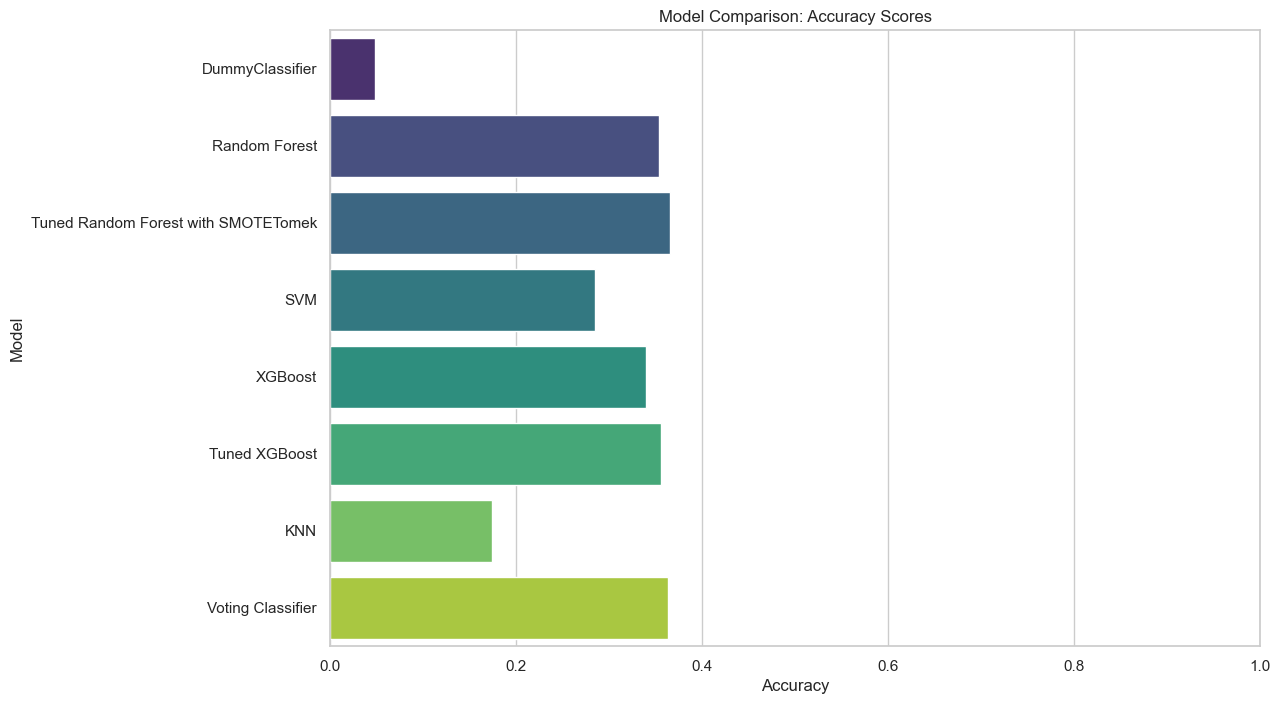

In [30]:
# Visualization of Model Accuracies
plt.figure(figsize=(12, 8))
sns.barplot(x="Accuracy", y="Model", data=comparison_df, palette="viridis")
plt.title("Model Comparison: Accuracy Scores")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.xlim(0, 1)
plt.show()

## 12. Further Post-Evaluation

To gain deeper insights into model performance and identify areas for improvement, we conduct additional evaluation steps.

### a. Cross-Validation Performance

Assess the consistency of model performance across different data splits using cross-validation.

In [31]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models to evaluate
models_cv = {
    "Random Forest": best_rf,
    "SVM": svm_clf,
    "XGBoost": best_xgb,
    "KNN": knn_clf,
    "Voting Classifier": voting_clf,
}

# Perform cross-validation
cv_results = {}
for model_name, model in models_cv.items():
    scores = cross_val_score(
        model, X_train_scaled, y_train_resampled, cv=skf, scoring="accuracy", n_jobs=-1
    )
    cv_results[model_name] = scores
    print(
        f"{model_name} Cross-Validation Accuracy: {scores.mean():.4f} ± {scores.std():.4f}"
    )

Random Forest Cross-Validation Accuracy: 0.8673 ± 0.0031
SVM Cross-Validation Accuracy: 0.5533 ± 0.0042
XGBoost Cross-Validation Accuracy: 0.8610 ± 0.0037
KNN Cross-Validation Accuracy: 0.6181 ± 0.0075
Voting Classifier Cross-Validation Accuracy: 0.8443 ± 0.0041


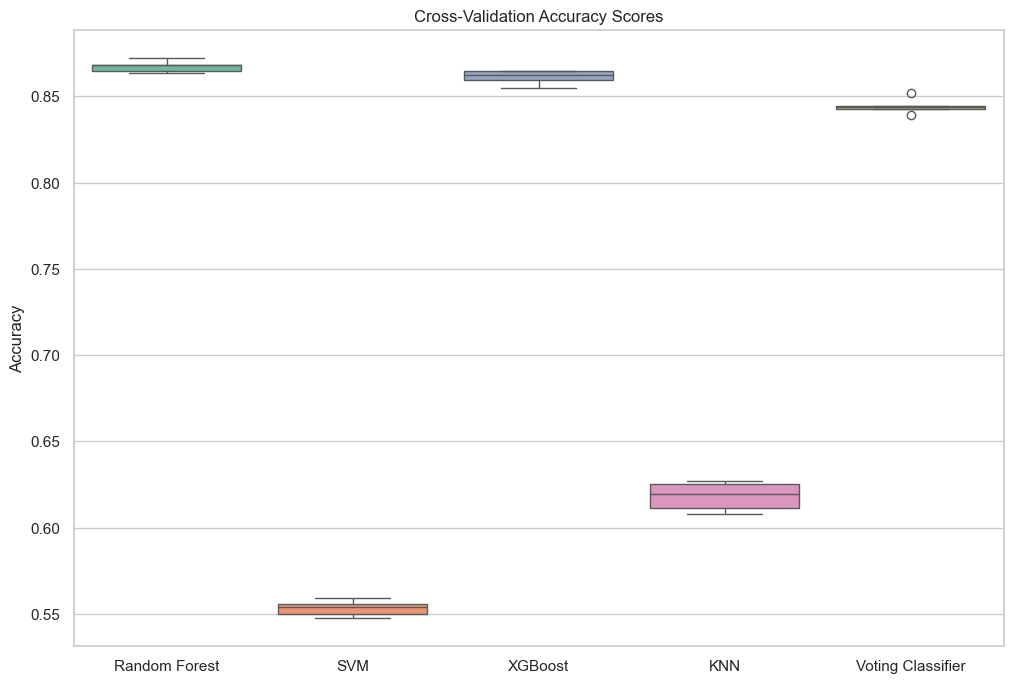

In [32]:
# Visualization of Cross-Validation Results
cv_df = pd.DataFrame(cv_results)

plt.figure(figsize=(12, 8))
sns.boxplot(data=cv_df, palette="Set2")
plt.title("Cross-Validation Accuracy Scores")
plt.ylabel("Accuracy")
plt.show()

### b. Feature Importance Analysis

Understand which features contribute most significantly to each model's predictions.

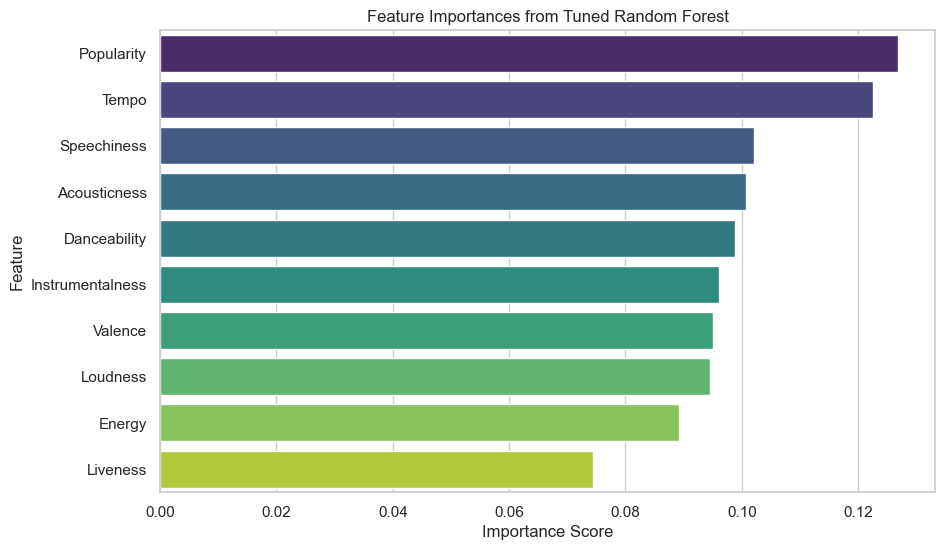

In [33]:
# Feature Importance for Tuned Random Forest

importances_rf = best_rf.feature_importances_
feature_importances_rf = pd.Series(importances_rf, index=feature_columns).sort_values(
    ascending=False
)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances_rf, y=feature_importances_rf.index, palette="viridis")
plt.title("Feature Importances from Tuned Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

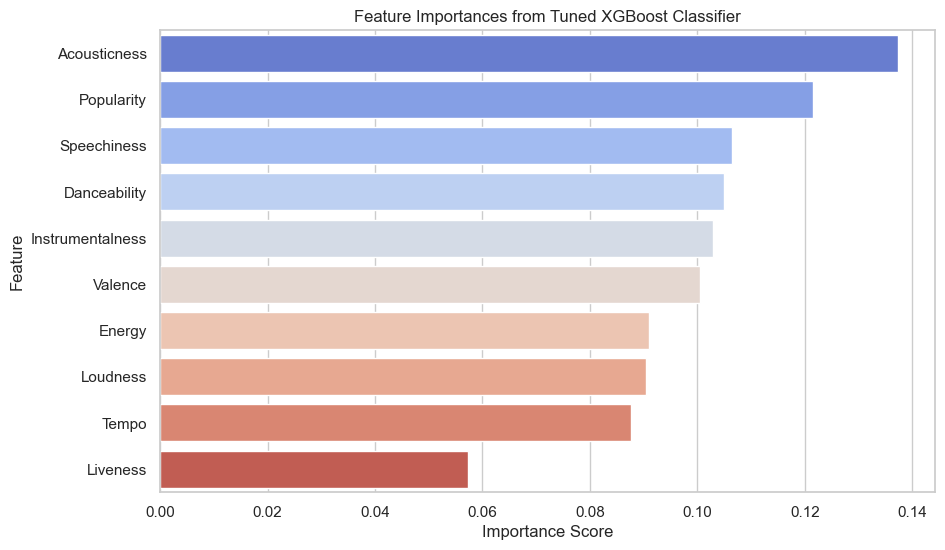

In [34]:
# Feature Importance for XGBoost

importances_xgb = best_xgb.feature_importances_
feature_importances_xgb = pd.Series(importances_xgb, index=feature_columns).sort_values(
    ascending=False
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=feature_importances_xgb, y=feature_importances_xgb.index, palette="coolwarm"
)
plt.title("Feature Importances from Tuned XGBoost Classifier")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()

### c. Precision-Recall Trade-off

Analyze the precision-recall trade-off for each model to understand their performance beyond accuracy.

In [35]:
# Binarize the output for multi-class precision-recall
y_test_binarized = label_binarize(
    y_test, classes=list(range(len(label_encoder.classes_)))
)
n_classes = y_test_binarized.shape[1]

In [36]:
# Function to plot Precision-Recall curve for multi-class


def plot_precision_recall(y_true, y_score, model_name):
    plt.figure(figsize=(10, 8))
    colors = cycle(
        [
            "navy",
            "turquoise",
            "darkorange",
            "cornflowerblue",
            "teal",
            "red",
            "green",
            "purple",
            "brown",
            "pink",
            "gray",
            "olive",
            "cyan",
            "magenta",
            "yellow",
            "black",
            "lime",
            "indigo",
            "gold",
        ]
    )
    for i, color in zip(range(n_classes), colors):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_score[:, i])
        average_precision = average_precision_score(y_true[:, i], y_score[:, i])
        plt.plot(
            recall,
            precision,
            color=color,
            label=f"Class {label_encoder.classes_[i]} (AP = {average_precision:.2f})",
        )

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve for {model_name}")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

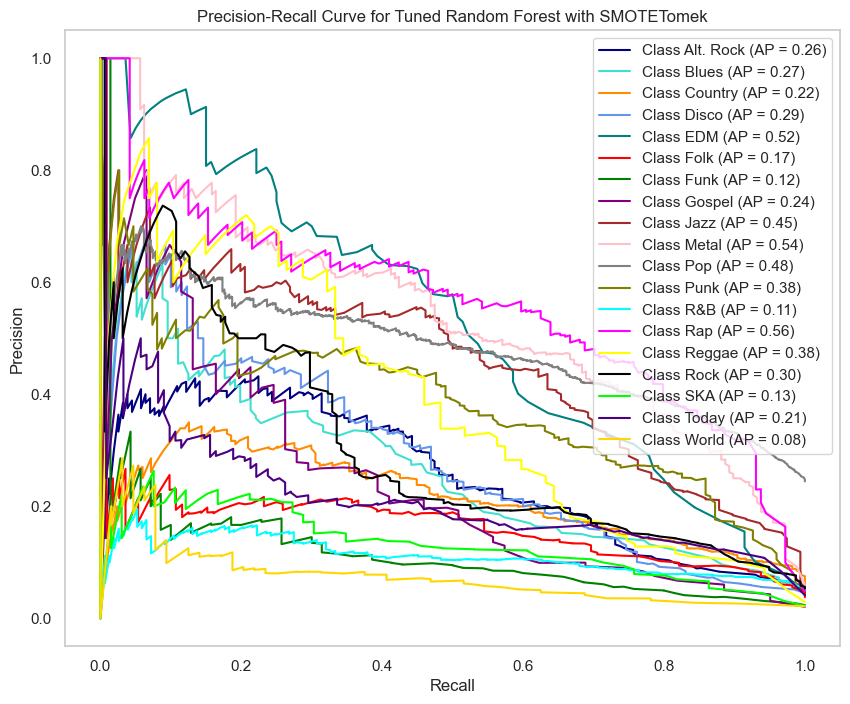

In [37]:
# Plot Precision-Recall for Tuned Random Forest with SMOTETomek
y_scores_rf = best_rf.predict_proba(X_test_scaled)
plot_precision_recall(
    y_test_binarized, y_scores_rf, "Tuned Random Forest with SMOTETomek"
)

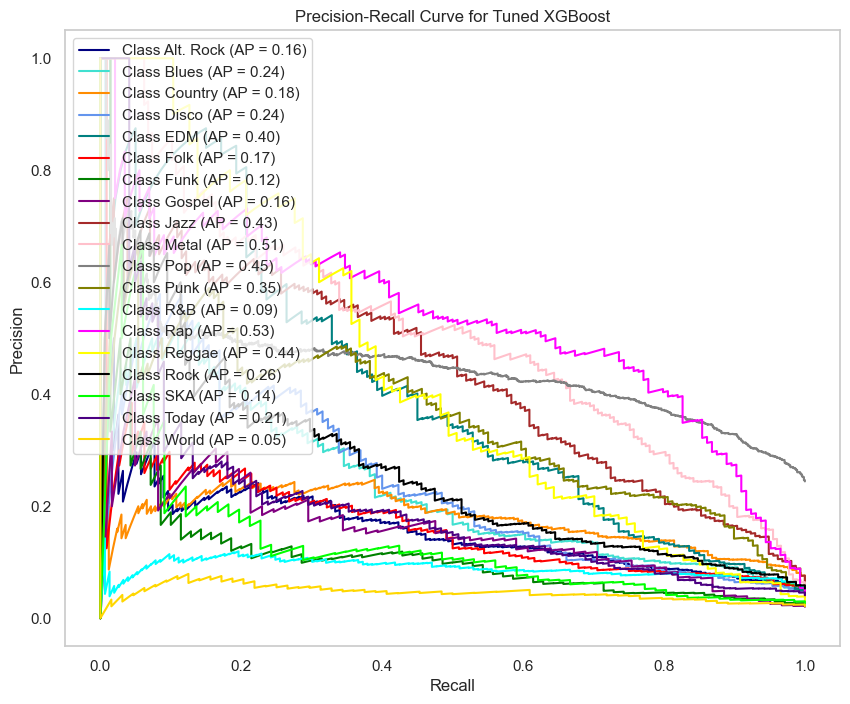

In [38]:
# Plot Precision-Recall for Tuned XGBoost
y_scores_xgb = best_xgb.predict_proba(X_test_scaled)
plot_precision_recall(y_test_binarized, y_scores_xgb, "Tuned XGBoost")